In [3]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

Using TensorFlow backend.


In [4]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns
import re

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [5]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 52.8 s, sys: 5.68 s, total: 58.5 s
Wall time: 58.5 s


In [6]:
from spacy.pipeline import EntityRecognizer


In [7]:
#ner = EntityRecognizer(nlp.vocab)


In [8]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

### take SRS descripitions for classification

In [9]:
"""%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
srsS=pd.read_pickle(inS_dir)
srsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),
                                                            srsS.index.get_level_values(1).str.lower()]) )"""

"%%time \ninS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'\nsrsS=pd.read_pickle(inS_dir)\nsrsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),\n                                                            srsS.index.get_level_values(1).str.lower()]) )"

In [10]:
"""sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

noDupSampleS=technical_meta_data_df.groupby(['Study']).head(n=1)['Sample']

specie_m=srsS.isin(['Mus musculus','Homo sapiens'])

attrib_m=srsS.index.get_level_values(1)=='scientific_name'

mySpecieSrs=srsS[specie_m&attrib_m].index.get_level_values(0).unique()

specie_srs_m=srsS.index.get_level_values(0).isin(mySpecieSrs)

attrib_a=srsS.index.get_level_values(1)
attrib_m=attrib_a=='description'


oneInStudy_m=srsS.index.get_level_values(0).isin(noDupSampleS.values)

srsS_sub=srsS[attrib_m&specie_srs_m&oneInStudy_m].drop_duplicates()

#make sure the code doesn't sample from outliers
#20 words https://www.ijcai.org/proceedings/2017/0578.pdf
wordCountS=srsS_sub.str.count(' ')
lem_m=(wordCountS<=60)&(wordCountS>=10)
srsS_sub=srsS_sub[lem_m]

inTestStrS=srsS_sub.sample(n=100,random_state=0)

### reload model"""

"sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'\n\ntechnical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)\n\nnoDupSampleS=technical_meta_data_df.groupby(['Study']).head(n=1)['Sample']\n\nspecie_m=srsS.isin(['Mus musculus','Homo sapiens'])\n\nattrib_m=srsS.index.get_level_values(1)=='scientific_name'\n\nmySpecieSrs=srsS[specie_m&attrib_m].index.get_level_values(0).unique()\n\nspecie_srs_m=srsS.index.get_level_values(0).isin(mySpecieSrs)\n\nattrib_a=srsS.index.get_level_values(1)\nattrib_m=attrib_a=='description'\n\n\noneInStudy_m=srsS.index.get_level_values(0).isin(noDupSampleS.values)\n\nsrsS_sub=srsS[attrib_m&specie_srs_m&oneInStudy_m].drop_duplicates()\n\n#make sure the code doesn't sample from outliers\n#20 words https://www.ijcai.org/proceedings/2017/0578.pdf\nwordCountS=srsS_sub.str.count(' ')\nlem_m=(wordCountS<=60)&(wordCountS>=10)\nsrsS_sub=srsS_sub[lem_m]\n\ninTestStrS=srsS_sub.sample(n=100,random_state=0)\n\n### reload model"

In [11]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')

%time model=load_model('./model/lstm.h5')

CPU times: user 21.1 s, sys: 7.24 s, total: 28.4 s
Wall time: 27.5 s


In [12]:
inTestStrS=pd.read_pickle('./Data/validation_description.pickle').head(n=100)

In [13]:
#inTestStrS.str.replace('[0-9 ]{2,}')

#### get baseline empty state

In [14]:
val_docs = list(nlp.pipe(' '))
val_X=get_features(val_docs,max_length=model.input_shape[1])

emptyState=model.predict_proba(val_X)[0,:]

### calculate NER score for each segment

In [861]:
import nltk
#from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [862]:
stopWords=stopwords.words('english')
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
phraseMax=7

In [870]:
#inTestStrS.str.split('[;.]',expand=True).stack()

In [18]:
myML=[]
myKeyL=[]
for i_th,sent in enumerate(tqdm(inTestStrS)):
    sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
    tokens=re.split(pattern=' ',string=sent)
    #
    tokens=list(filter(lambda token:(token!='') and (token not in stopWords)  ,tokens))
    sent=' '.join(tokens)
    ###keep track of each token
    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
    #for n_gram in range(1,len(tokens)+1):
    myNMax=min( [len(tokens),phraseMax])
    #print (myNMax)
    for n_gram in range(1,myNMax+1):
        
        grams=list(map(lambda L:" ".join(L),list(ngrams(tokens,n_gram))))
        val_docs = list(nlp.pipe(grams))
        val_X=get_features(val_docs,max_length=model.input_shape[1])
        predictM=model.predict_proba(val_X)
        tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
        empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.1
        moreThanTwoValToken_mask=(val_X!=0).sum(axis=1)>=2
        tmpDf[empty_mask&moreThanTwoValToken_mask]=0
        
        for i,gram in enumerate(tmpDf.index): #i: track the each token position
            #for j,one_gram in enumerate(gram.split(' ')):
            i_end=i+n_gram+1
            textBefore=" ".join(tokens[:i]) + ('' if i==0 else ' ')
            start_char_pos=len(textBefore)
            myKeyL.append((i_th,sent,n_gram,i,i_end,gram,start_char_pos)) 
            myML.append(tmpDf.iloc[i])
                #(tmpDf.iloc[i])
        #tmpDf2=tmpDf[(tmpDf>=0.5).any(axis=1)]
        

        #update score in table by 
        #for i,gram in enumerate(tmpDf.index):# for each n-gram, #for each word add the score
        #        for j,one_gram in enumerate(gram.split(' ')): #check the score of each split compared to current ones
        #                scoreDf.iloc[i+j]=scoreDf.iloc[i+j]+(tmpDf.iloc[i])
        #                #scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
        
    #if i_th>10:
    #    break

100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


In [19]:
#tmp_doc=ner.pipe(inTestStrS.iloc[:2].values)
#list(tmp_doc)

In [20]:
#textBefore

In [21]:
#tmp=myKeyL[2]
#tmp[1][6:10]

In [22]:
#tmpDf.iloc[i]

In [23]:
#
#tmpDf.iloc[i]

In [24]:
"""thresholdS=pd.Series(
   {'SCIENTIFIC_NAME': 0.26689231395721436,
 'cell type': 0.10027739964425564,
 'disease': 0.15823280811309814,
 'genotype': 0.09954400360584259,
 'geo_loc_name': 0.6163255572319031,
 'sex': 0.6458048224449158}
)"""

"thresholdS=pd.Series(\n   {'SCIENTIFIC_NAME': 0.26689231395721436,\n 'cell type': 0.10027739964425564,\n 'disease': 0.15823280811309814,\n 'genotype': 0.09954400360584259,\n 'geo_loc_name': 0.6163255572319031,\n 'sex': 0.6458048224449158}\n)"

In [524]:
mergedDf=pd.concat(myML,keys=myKeyL,axis=1).T

In [525]:
mergedDf.index.names=['i_thSrs','orig_text','n','i','i_end','token','ith_char_pos']

In [526]:
#mergedDf

## entity recognition

In [766]:
n_threshold=2

In [767]:
mergedDf_sub=mergedDf[mergedDf.index.get_level_values('n')>=n_threshold]

In [807]:
max_m=mergedDf_sub.max(axis=1)>0.2
m_val=((mergedDf_sub>0.05).sum(axis=1)==1)&max_m&(~mergedDf_sub.index.get_level_values('token').str.contains('[0-9 ]+ [0-9 ]+'))


In [808]:
tmpDf=pd.DataFrame({'predicted':mergedDf_sub[m_val].idxmax(axis=1),'score':mergedDf_sub[m_val].max(axis=1)})

In [809]:
scoreSortedDf=tmpDf[m_val].sort_values(['orig_text','i','score'],ascending=False).reset_index(
)



/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [810]:
## get all overlapping regions
v=scoreSortedDf.copy()
scoreSortedDf=scoreSortedDf.assign(OverlapGroup=(len(inTestStrS)*v.i_thSrs+ 
                                          (v.i_end - v.i.shift(-1)).shift().lt(0).cumsum()))


In [811]:
scoreSortedDf.head()

,i_thSrs,orig_text,n,i,i_end,token,ith_char_pos,predicted,score,OverlapGroup
0,84,tdTomato cardiomyocytes Mus musculus CAG creER...,2,14,17,mapping identifies,106,genotype,0.818595,8400
1,84,tdTomato cardiomyocytes Mus musculus CAG creER...,3,13,17,fate mapping identifies,101,genotype,0.582801,8400
2,84,tdTomato cardiomyocytes Mus musculus CAG creER...,2,12,15,Hypoxia fate,93,treatment,0.203004,8400
3,84,tdTomato cardiomyocytes Mus musculus CAG creER...,2,8,11,tdTomato transgenic,58,genotype,0.660796,8400
4,84,tdTomato cardiomyocytes Mus musculus CAG creER...,2,7,10,R26R tdTomato,53,genotype,0.764524,8400


In [812]:
hitDf=scoreSortedDf.sort_values(['OverlapGroup','score'],ascending=False).drop_duplicates(['OverlapGroup','predicted']
                                                                                   ).sort_values('orig_text')

In [813]:
hitDf['token_len']=hitDf['token'].str.len()

In [814]:
hitDf['recovered_txt']=hitDf.apply(
    lambda tmpS2:tmpS2.loc['orig_text'][tmpS2.loc['ith_char_pos']:(tmpS2.loc['ith_char_pos']+tmpS2.loc['token_len'])],axis=1)

In [815]:
print ('is it extraction: ',(hitDf.recovered_txt==hitDf.token).all())

is it extraction:  True


{"content":"cd players and tuners","annotation":[{"label":["Category"],"points":[{"start":0,"end":1,"text":"cd"}]},{"label":["Category"],"points":[{"start":3,"end":9,"text":"players"}]},{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}],"extras":{"Name":"columnName","Class":"ColumnValue"}}
\
Content contains input text, annotation has the labeled content, extras is for some extra columns that you want to show with each row.



### visualize using spacy

In [816]:
myClassToId={}
for myClass in le.classes_:
    myClassToId[myClass]=nlp.vocab.strings.add(myClass)


In [817]:
classToSpacyId=pd.Series(myClassToId)

In [818]:
inDisplayHitDf=hitDf.copy()

In [819]:
inDisplayHitDf['predicted_entity_id']=classToSpacyId.loc[inDisplayHitDf['predicted']].values

In [820]:
orig_textL=sorted(inDisplayHitDf['orig_text'].unique())


In [832]:
orig_text=orig_textL[50]

In [833]:
print (orig_text)

Protocols Hela cells treatment NC ASO snoRD50a ASOs treated concentration 50 nM used RNAi max ASO transfection harvest cells 2 days transfection RNAs recovered Fip1 antibodies ligated onto 3 adaptor RT reactions carried converting RNAs cDNA cDNAs circularized digested PCR amplified PCR product sent sequencing


In [834]:
hitDf_groupby=inDisplayHitDf.groupby('orig_text')

In [835]:
inRecordDisplayDf=hitDf_groupby.get_group(orig_text)

In [836]:
#orig_text=orig_textS
doc=nlp(orig_text)

In [837]:
for _,tmpS in inRecordDisplayDf.iterrows():
    EVENT=tmpS['predicted_entity_id']
    entity=(EVENT,tmpS['i'],tmpS['i_end']-1)# this the correct one
    print (entity)
    doc.ents+=(entity,)

(17998780750743588112, 7, 10)
(10400321950887182855, 19, 21)
(188603156775490070, 1, 3)


In [838]:
classToSpacyId

SCIENTIFIC_NAME     8276535918164649739
age                10400321950887182855
cell type            188603156775490070
disease             5781322434961390358
genotype           18166236633804328029
geo_loc_name       12368356759224854017
treatment          17998780750743588112
dtype: uint64

In [839]:
current_palette = sns.color_palette()


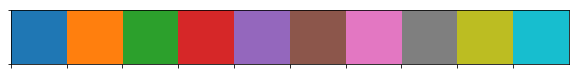

In [840]:
current_palette
sns.palplot(current_palette)


In [841]:
import matplotlib

In [845]:
colors = {ent.upper():matplotlib.colors.to_hex(myColor)  for myColor,ent in zip(current_palette,classToSpacyId.index)}

options = {'ents': classToSpacyId.index.str.upper(),
           'colors': colors}

spacy.displacy.render(doc, style='ent',jupyter=True,options=options)

In [853]:
html=spacy.displacy.render([doc,doc], style='ent',page=True,options=options)

In [854]:
with open('./Data/displacy.html','w') as f:
    f.write(html)
    

In [855]:
!echo $PWD/./Data/displacy.html

/data/cellardata/users/btsui/DEEP_NLP/NLP_spacy/./Data/displacy.html


In [804]:
asdasdasd

NameError: name 'asdasdasd' is not defined

In [757]:
asdfasf

NameError: name 'asdfasf' is not defined

In [758]:
nerName='cell type'
nlp.vocab.strings.add(nerName)
EVENT = nlp.vocab.strings[nerName]


In [759]:
EVENT

188603156775490070

In [760]:
doc=nlp(u"t cell")

In [ ]:
#use 
entity=(EVENT,0,len(u"t cell"))
doc.ents+=(entity,)

In [ ]:
spacy.displacy.render(doc, style='ent',jupyter=True)


In [ ]:


def add_event_ent(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    entity = (EVENT, start, end)
    doc
    doc.ents += (entity,)

In [ ]:
myToke.label=''

In [ ]:
doc.ents+=tuple(['cell type'])

In [ ]:
#span=doc[:]

In [ ]:
#nlp.

In [ ]:
#span.label='cell type'

# export to dataturk

In [ ]:
import json

In [ ]:
def myF(tmpS1):
    return {"label":[tmpS1.loc['predicted']],"points":{'start':tmpS1.loc['i'],
     'end':tmpS1.loc['i_end']-1,'text':tmpS1.loc['token']},

        }

inAnnotDf=hitDf.copy()
myL=[]
for text,subDf in inAnnotDf.groupby(['orig_text']):
    oneAnnotatedLine={"content":text,'annotation':list(subDf.apply(myF,axis=1)),
                                "extras":None,
        "metadata":{"first_done_at":1535058971000,
                                     "last_updated_at":1535058971000,"sec_taken":0,
                                "last_updated_by":"EEOBDlEO48T6gzo0KHvT0IkqZnn2"}}
    myL+=[json.dumps(oneAnnotatedLine)]
    

In [ ]:
#myL[0]

In [ ]:
with open( './Data/validation.ngram.json.txt','w')as f:
    f.write("\n".join(myL[:1]))


In [ ]:
!echo $PWD/./Data/validation.ngram.json.txt

In [ ]:
print(",".join(le.classes_))

In [ ]:
!head 

In [ ]:
oneAnnotatedLine['annotation'][0]

In [ ]:
exampleDict={"content":"cd players and tuners","annotation":[{"label":["Category"],"points":[{"start":0,"end":1,"text":"cd"}]},{"label":["Category"],"points":[{"start":3,"end":9,"text":"players"}]},{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}],"extras":{"Name":"columnName","Class":"ColumnValue"}}
exampleDict

In [ ]:
#{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}
#myL=[]
#{"content":text,"annotation":}

In [ ]:
inAnnotDf.iloc[:1].to_json()

In [ ]:
text

In [ ]:
hitDf['i_thSrs'].value_counts()

In [ ]:
hitDf['i_thSrs'].value_counts()

In [ ]:
hitDf.sort_values(['i_thSrs'])

### scratch

In [ ]:
myNameL=list(VC.index.names)
myNameL[-1]='Predicted_NE'
VC.index.names=myNameL

In [ ]:
#### for each n-gram, there is the same start site, use 

In [ ]:
#.drop_duplicates(['orig_text','Predicted_NE'])


In [ ]:
#mergedDf
#take on any length, 

In [ ]:
tmpDf=(mergedDf>thresholdS).loc['ESCs WT replicate1 mRNA Mad2l2'].stack().reset_index()

In [ ]:
tmpDf.columns=['n','n-gram','attrib','passThreshold']

In [ ]:
#tmpDf['n-gram']

In [ ]:
tmpDf[tmpDf.passThreshold]
      

In [ ]:
tmpS[tmpS].groupby(level=[1,2]).size()

In [ ]:
tmpDf2.idxmax(axis=1)

In [ ]:
mergedDf=pd.concat(myML,keys=list(inTestStrS))

In [ ]:
numeric_token_m=mergedDf.index.get_level_values(0).str.contains('^\d+$')

In [ ]:
mergedSubDf=mergedDf[~numeric_token_m].copy()#.loc[:,mergedDf.columns!='age']

In [ ]:
threshold=0.800000
mergedSubDf['undetected']=threshold
#noAmbigM=(mergedSubDf>=threshold).sum(axis=1)>=1 #this mark screw up the confoudning boundary 
mergedSubDf.loc[:,'undetected']=threshold

In [ ]:
predDf=mergedSubDf.idxmax(axis=1).to_frame()

In [ ]:
predDf.index.names=['Freetext','Token']
predDf['token_numeric']=predDf.index.get_level_values('Token').str.contains('^\d+$')

In [ ]:
excel=pd.ExcelWriter('./Results/for_curation.xlsx')
predDf[~predDf['token_numeric']].to_excel(excel)
excel.close()

# scratch

In [ ]:
asdasd

In [ ]:
predDf[~predDf['token_numeric']]

In [ ]:
!echo $PWD/./Results/for_curation.xlsx

In [ ]:
#predDf

In [ ]:
!echo $PWD/./Results/for_curation.xlsx

In [ ]:
predDf[~predDf['token_numeric']].to_csv('tmp.csv')

In [ ]:
#!rm tmp.csv

In [ ]:
import numpy as np

In [ ]:
#replace with duplicated states
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])

In [ ]:
emptyState=mergedSubDf.groupby(mergedSubDf.columns.tolist(),as_index=False).size().sort_values().index[-1]
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])
print (emptyState)

In [ ]:
noPredM=((mergedSubDf-emptyState).abs()<0.1).all(axis=1)
mergedSubDf[(~noPredM)&(mergedSubDf>0.5).sum(axis=1)==1]

In [ ]:
#good examples: HAP1 LMTK3-KO cells, stimulated with WNT3, replicate R2

In [ ]:
mergedSubDf.loc['HAP1 CCK4-KO cells, stimulated with RESV, replicate R1']

In [ ]:
mergedSubDf[].iloc[0].values

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
##among the ones with >0.5, take the ones that are unique
sns.heatmap(data=(scoreDf>0.6).T)

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
### among the ones with clear boundry, it can classify well. 


"""
argue that it can salvage the data correctly. Among those sentences, 

take >0.5 as boundary, run top 10000 sentences 
"""
scoreDf

### show one

In [ ]:
#sent='Human histone H3 di-methylated at lysine 4 (H3K4me2) in human blood CD4+ T cells, targeted using Abcam antibody ab7766'#inTestStrS.iloc[5]
sent='RNA-seq of total RNA from Z/Edn2; Six3-Cre mouse retina	'
print(sent)

In [ ]:
#sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
#for n_gram in range(1,len(tokens)):
n_gram=8
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
#print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,max_length=model.input_shape[1])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
#tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
tmpDf[empty_mask]=0

fig,ax=plt.subplots(figsize=(3,2.5*4))
sns.heatmap(tmpDf,annot=True,ax=ax,vmin=0,vmax=1.0,fmt='.2f',cbar=None)
#ax.set_xticklabels([])
"""break

#each n gram only advange 
for i,gram in enumerate(tmpDf.index):# for ec
    for j,one_gram in enumerate(gram.split(' ')):
        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
"""

In [ ]:
#for each one, makes a prediction on the term, to see what it is supposed to be. 

### test one

In [ ]:
sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    predictM=model.predict_proba(val_X)

    tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
    empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
    tmpDf[empty_mask]=0

    """
    each n gram only advange 
    """
    for i,gram in enumerate(tmpDf.index):# for ec
        for j,one_gram in enumerate(gram.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))


In [ ]:
threshold=0.2
scoreDf[scoreDf<=threshold]=0
scoreDf['undetected']=threshold

scoreDf.idxmax(axis=1)

In [ ]:
sns.heatmap(scoreDf,annot=True)

In [ ]:
tokens

In [ ]:
sns.heatmap(scoreDf.T,annot=True)

In [ ]:
sexS=srsS[srsS.index.get_level_values(1)=='sex']

In [ ]:
sexS.value_counts()

In [ ]:
tmpSubSrsS1=srsS[srsS.str.contains('rna',case=False)]

In [ ]:
tmpSubSrsS1

In [ ]:
#!python -m spacy download en_core_web_sm
